In [ ]:
# dataset link
#https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset?resource=download

In [67]:
#importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, Dropout, Rescaling, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [57]:
#trian image loading #224
train_data = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128,128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 75722 files belonging to 41 classes.


In [58]:
#validation image loading
val_data = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128,128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 19006 files belonging to 41 classes.


In [80]:
#building the model
model = Sequential()

# Add Rescaling Layer as the first layer
model.add(Rescaling(1./255, input_shape=(128, 128, 3)))

# Convolutional Block 1
model.add(Conv2D(filters=32,kernel_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(MaxPooling2D(pool_size=2,strides=2))

# Convolutional Block 2
model.add(Conv2D(filters=64,kernel_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(MaxPooling2D(pool_size=2,strides=2))

# Convolutional Block 3
model.add(Conv2D(filters=128,kernel_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(MaxPooling2D(pool_size=2,strides=2))

# Convolutional Block 4
model.add(Conv2D(filters=256,kernel_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(MaxPooling2D(pool_size=2,strides=2))

model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(units=41, activation='softmax')) 

In [81]:
#compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
#summery of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 64)       

In [83]:
#training the model
training_history = model.fit(x=train_data, validation_data=val_data, epochs=10, verbose=1)

Epoch 1/10
2367/2367 [==============================] - 862s 364ms/step - loss: 2.3531 - accuracy: 0.3120 - val_loss: 1.5774 - val_accuracy: 0.5238
Epoch 2/10
2367/2367 [==============================] - 966s 407ms/step - loss: 1.6311 - accuracy: 0.4768 - val_loss: 1.0229 - val_accuracy: 0.6947
Epoch 3/10
2367/2367 [==============================] - 914s 385ms/step - loss: 1.2759 - accuracy: 0.5839 - val_loss: 1.0162 - val_accuracy: 0.7015
Epoch 4/10
2367/2367 [==============================] - 942s 397ms/step - loss: 1.0180 - accuracy: 0.6650 - val_loss: 0.7671 - val_accuracy: 0.7587
Epoch 5/10
2367/2367 [==============================] - 913s 385ms/step - loss: 0.7545 - accuracy: 0.7494 - val_loss: 0.8309 - val_accuracy: 0.7964
Epoch 6/10
2367/2367 [==============================] - 1012s 427ms/step - loss: 0.5450 - accuracy: 0.8218 - val_loss: 0.3065 - val_accuracy: 0.9001
Epoch 7/10
2367/2367 [==============================] - 997s 419ms/step - loss: 0.3875 - accuracy: 0.8734 - val

In [84]:
#Training accuracy
train_loss, train_acc = model.evaluate(train_data)
print('Training accuracy:', train_acc)

2367/2367 [==============================] - 925s 388ms/step - loss: 0.0974 - accuracy: 0.9690
Training accuracy: 0.9690314531326294


In [85]:
#Validation accuracy
val_loss, val_acc = model.evaluate(val_data)
print('Validation accuracy:', val_acc)

594/594 [==============================] - 205s 332ms/step - loss: 0.1523 - accuracy: 0.9548
Validation accuracy: 0.9547511339187622


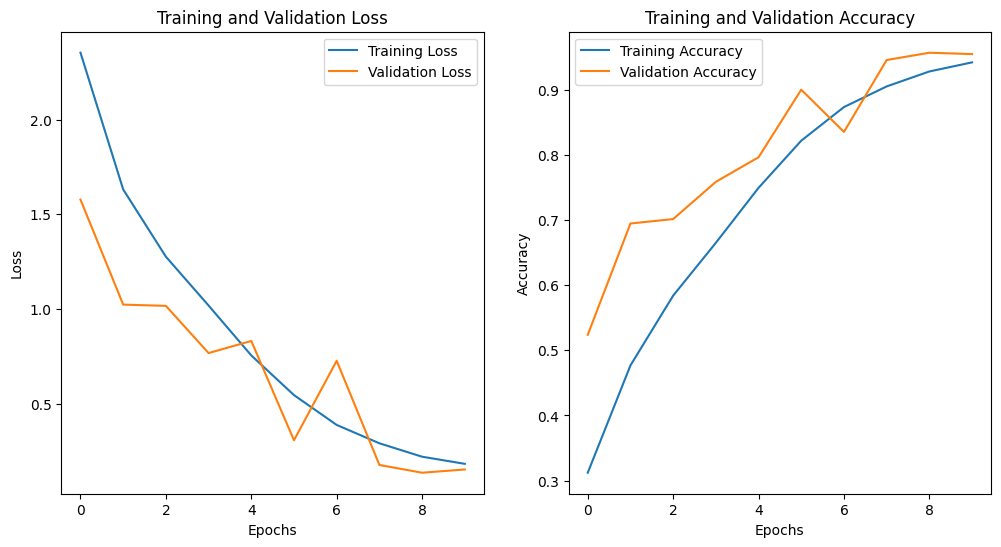

In [86]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [87]:
testing_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
class_names = testing_set.class_names
print(class_names)

Found 19006 files belonging to 41 classes.
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Citrus_Canker_Diseases_Leaf', 'Orange___Citrus_Nutrient_Deficiency_Yellow_Leaf_Orange', 'Orange___Haunglongbing_(Citrus_greening)', 'Orange___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato__

In [88]:
predictions = model.predict(testing_set)
predicted_categories = tf.argmax(predictions, axis=1)

594/594 [==============================] - 29s 46ms/step


In [89]:
true_cat = tf.concat([y for x, y in testing_set], axis=0)
true_categories = tf.argmax(true_cat, axis=1)

In [90]:
true_categories.numpy()

array([ 0,  0,  0, ..., 40, 40, 40], dtype=int64)

In [91]:
predicted_categories.numpy()

array([ 0,  0,  0, ..., 40, 40, 40], dtype=int64)

In [92]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(true_categories, predicted_categories), tf.float32))
print(f'Accuracy: {accuracy.numpy() * 100}%')

Accuracy: 95.47511339187622%


In [93]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)

In [94]:
# Precision, Recall, & Fscore
print(classification_report(true_categories,predicted_categories,target_names=class_names))

                                                        precision    recall  f1-score   support

                                    Apple___Apple_scab       0.98      0.95      0.97       504
                                     Apple___Black_rot       1.00      0.98      0.99       497
                              Apple___Cedar_apple_rust       1.00      0.96      0.98       440
                                       Apple___healthy       0.79      1.00      0.88       502
                                   Blueberry___healthy       0.93      0.98      0.95       454
              Cherry_(including_sour)___Powdery_mildew       1.00      0.93      0.97       421
                     Cherry_(including_sour)___healthy       0.96      1.00      0.98       456
    Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.90      0.93       410
                           Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
                   Corn_(maize)___North

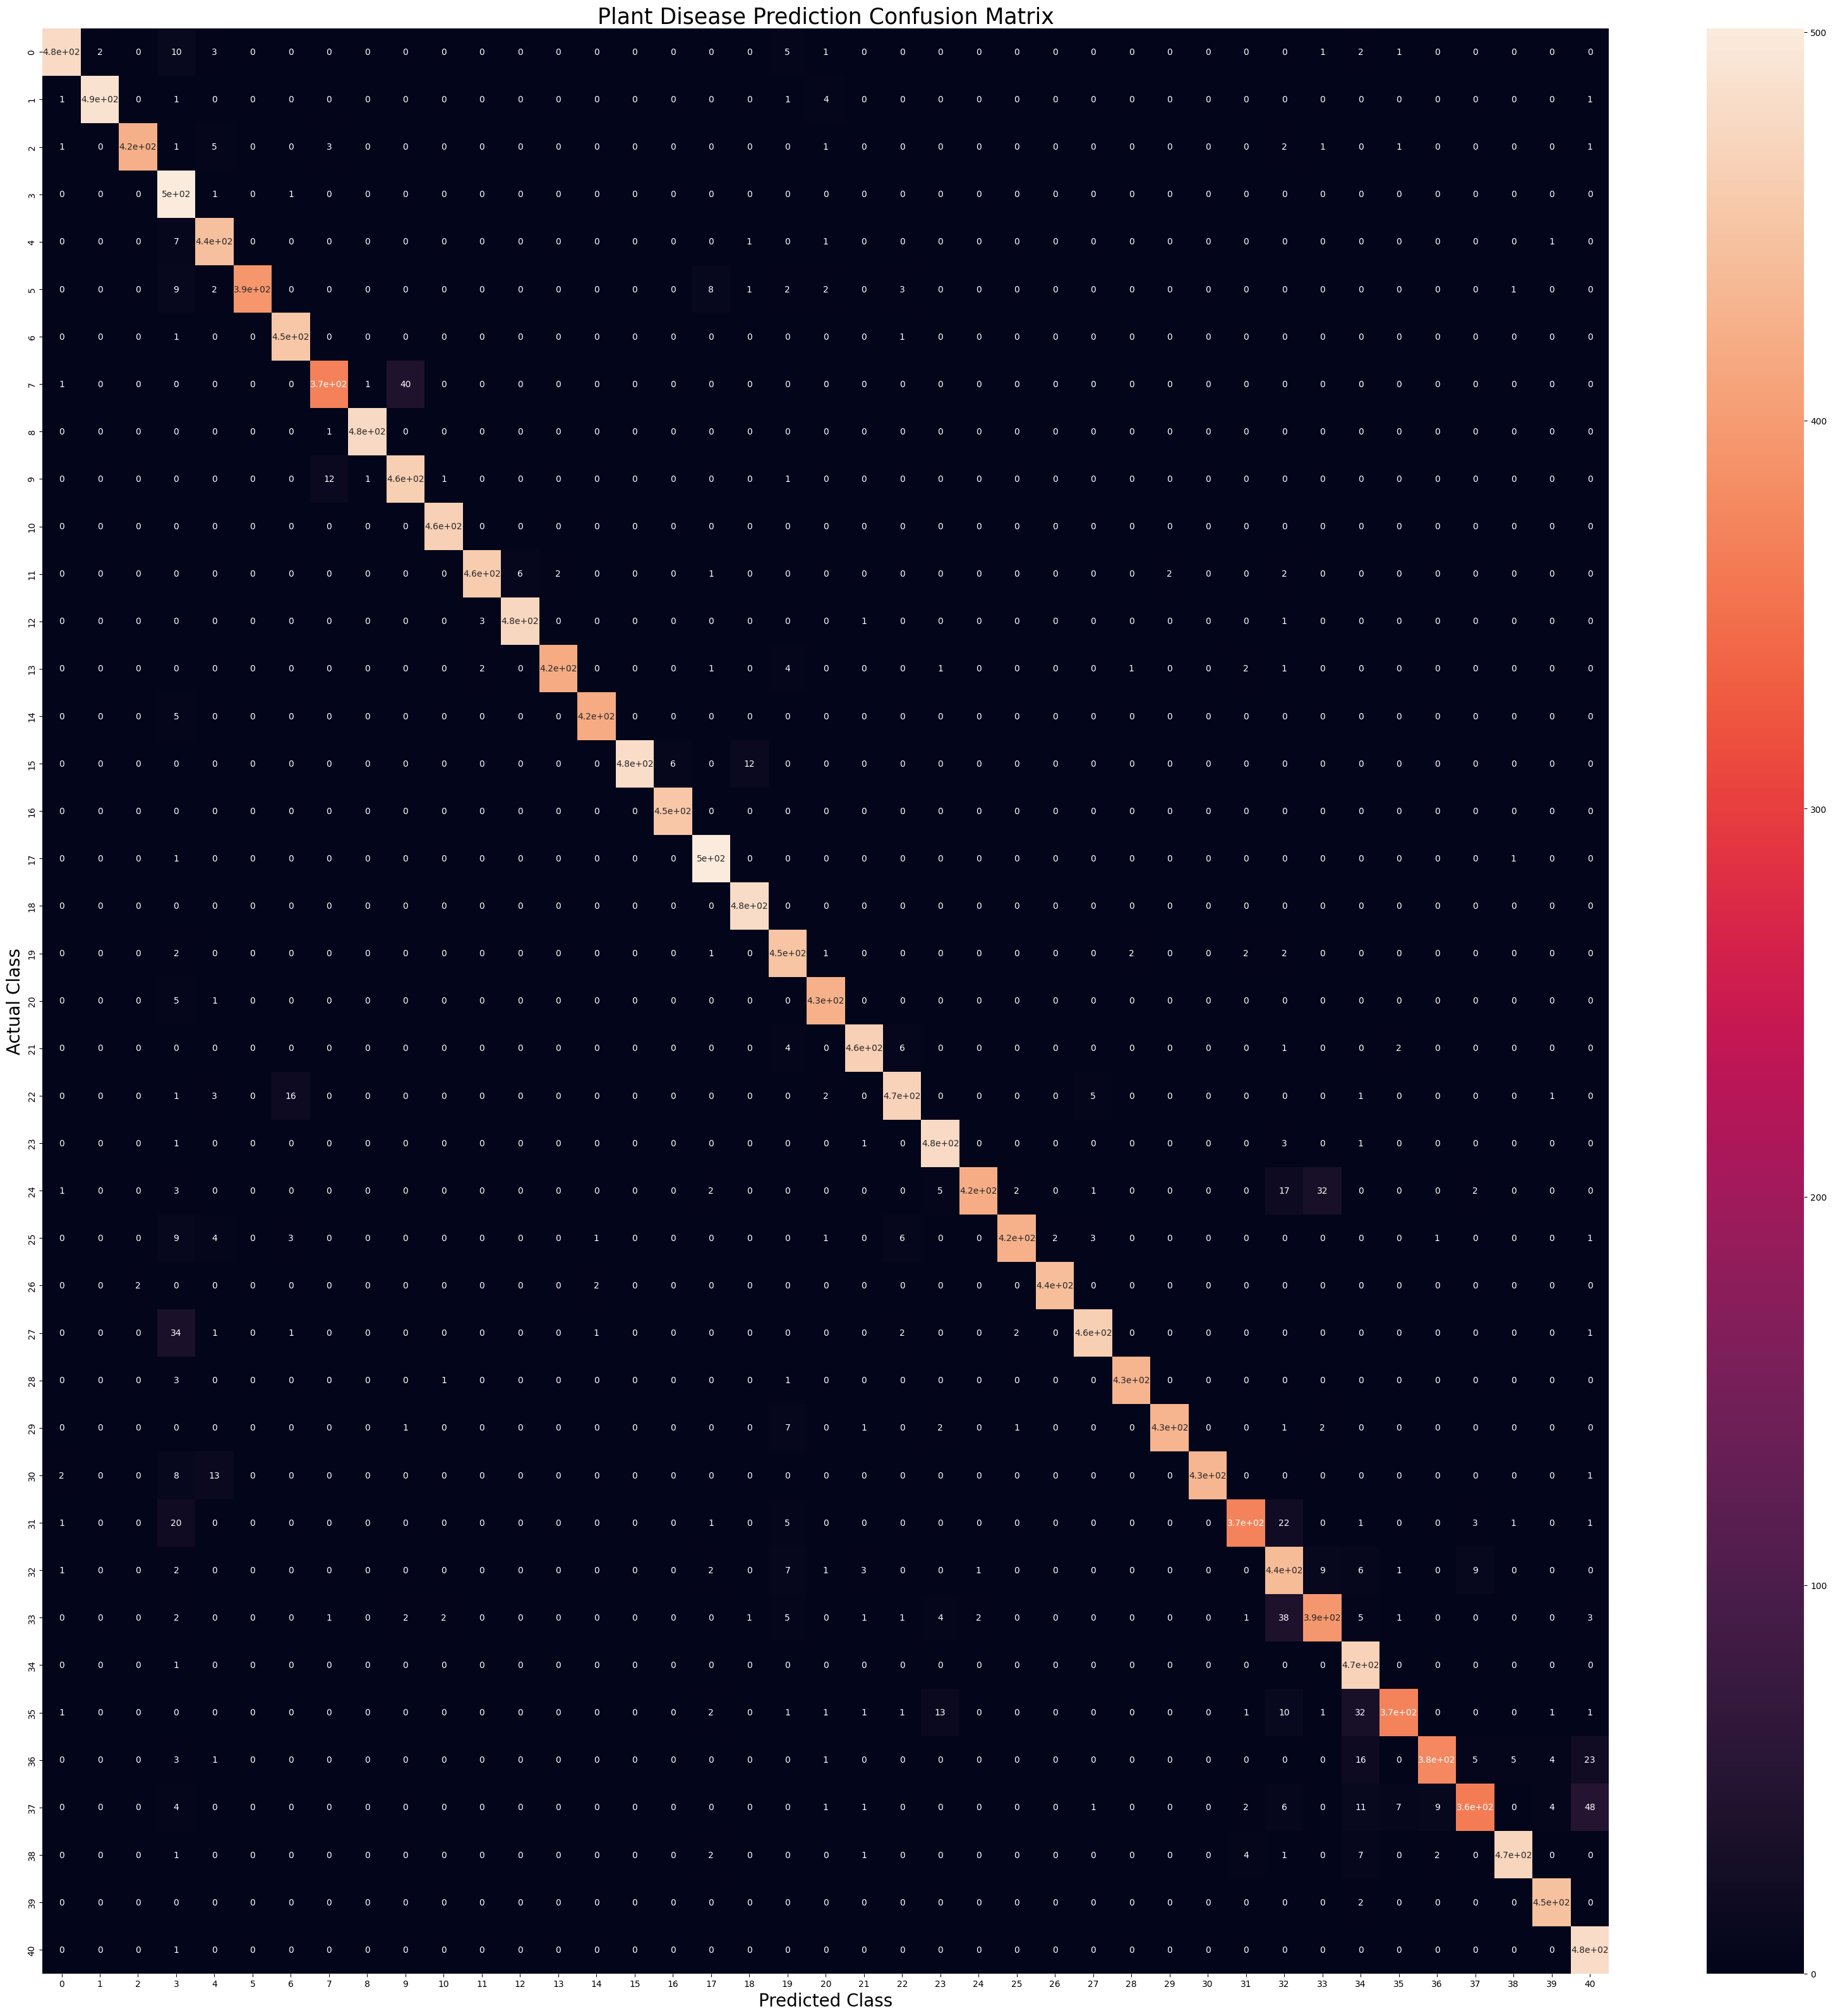

In [95]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()

In [96]:
#saving the model
model.save('plant_disease_detection_model.keras')

In [1]:
#libraries for model to run
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [98]:
# Save class names to a text file
with open('class_names.txt', 'w') as file:
    for class_name in testing_set.class_names:
        file.write(f"{class_name}\n")

In [2]:
#loading the model
cnn_model = tf.keras.models.load_model('plant_disease_detection_model.keras')

In [3]:
# Load class names from the file
with open('class_names.txt', 'r') as file:
    loaded_class_names = [line.strip() for line in file]

print(loaded_class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Citrus_Canker_Diseases_Leaf', 'Orange___Citrus_Nutrient_Deficiency_Yellow_Leaf_Orange', 'Orange___Haunglongbing_(Citrus_greening)', 'Orange___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'To

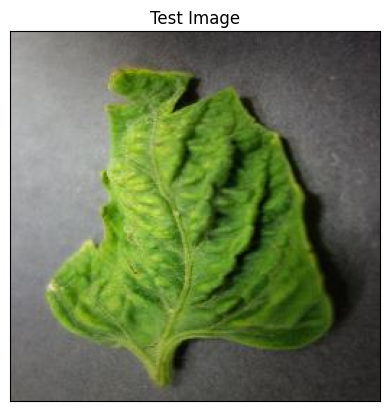

In [160]:
#Test Image Visualization
image_path = 'test/TomatoYellowCurlVirus4.JPG'
# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image 
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [161]:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = cnn_model.predict(input_arr)

1/1 [==============================] - 0s 32ms/step


In [162]:
print(predictions)

[[5.59759758e-13 6.45143848e-21 2.46539300e-09 4.59940919e-10
  2.67311433e-12 2.03203683e-07 3.73535903e-21 1.91794158e-13
  4.15924332e-16 1.38232785e-12 5.84148940e-13 1.12476091e-17
  8.02960433e-17 6.61849416e-16 1.34431515e-17 6.80879684e-15
  1.30791156e-22 9.16223541e-08 2.39585234e-13 5.04752320e-14
  2.43590297e-17 1.20791649e-11 1.32512043e-13 1.19202847e-18
  1.19001156e-10 3.68538672e-11 8.12068468e-11 2.34802818e-14
  1.96881316e-13 1.31029121e-18 1.67760302e-17 1.12725484e-05
  3.67546107e-07 1.18449361e-05 9.41419785e-05 5.37398348e-10
  2.11371895e-04 1.46388288e-08 9.99670744e-01 9.04416819e-12
  4.97888449e-12]]


In [158]:
result_index = np.argmax(predictions) #Return index of max element
print(result_index)

38


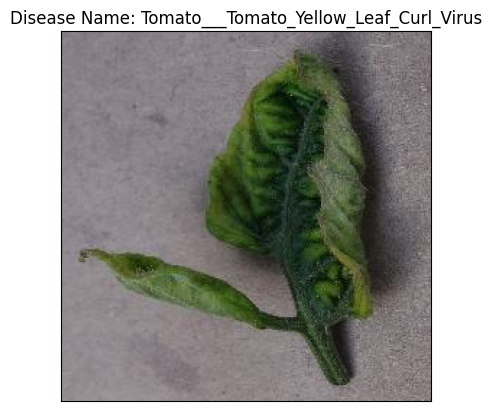

In [159]:
# Displaying the disease prediction
model_prediction = loaded_class_names[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()